Load the one-hot encoding and the mix  
Create a model that takes the mix as input and outputs the one-hot encoding  
Train the model  
Save the model  
Load the model  
Test the model  
Save the test results  
Load the test results  
Plot  

In [81]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import librosa
from tqdm import tqdm


In [82]:
# Example encoding of a label [1, 1, 0, 1, 0, 0]

irmas_labels = ["cel", "cla", "flu", "gac", "gel", "org", "pia", "sax", "tru", "vio", "voi"]

# Define the labels 
# cello, clarinet, flute, acoustic guitar, electric guitar, organ, piano, saxophone, trumpet, violin, and human singing voice
label_names = ["cello", "clarinet", "flute", "guitar", "guitar", "organ", "piano", "saxophone", "trumpet", "violin", "voice"]
n_classes = len(label_names)


In [94]:
# Load the data
data_dir = "datasets/IRMAS-TrainingData-images"
image_size = (130, 128)
batch_size = 32

train_ds, test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='categorical',
    color_mode='grayscale',
    batch_size=batch_size,
    image_size=image_size,
    shuffle=True,
    validation_split=0.1,
    subset = 'both',
    seed = 123,
)

Found 3764 files belonging to 7 classes.
Using 3388 files for training.
Using 376 files for validation.


Classes: ['cel', 'cla', 'flu', 'gac', 'sax', 'tru', 'vio']


2024-11-29 13:48:59.298411: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


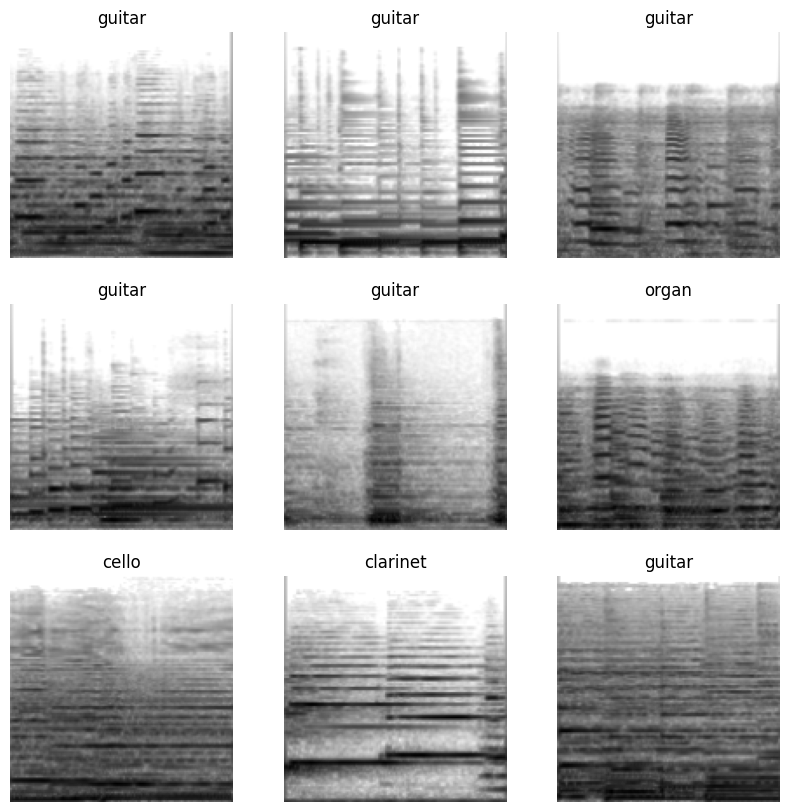

In [95]:
print(f"Classes: {train_ds.class_names}")

for batch in train_ds.take(1).as_numpy_iterator():
    imgs, labels = batch
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(imgs[i], cmap='gray')
        plt.title(label_names[np.argmax(labels[i])])
        plt.axis("off")
plt.show()


In [96]:
print(f"Training data size (batches): {train_ds.cardinality()}")
print(f"Testing data size (batches): {test_ds.cardinality()}")


Training data size (batches): 106
Testing data size (batches): 12


In [97]:
def add_conv_block(model, num_filters=32, dropout_rate=0.25):
    model.add(keras.layers.Conv2D(num_filters, kernel_size=(3, 3), activation='relu'))
    model.add(keras.layers.Conv2D(num_filters, kernel_size=(3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(keras.layers.Dropout(dropout_rate))
    return model

In [117]:
model = keras.Sequential()
model.add(keras.Input(shape=(image_size[0], image_size[1], 1)))

add_conv_block(model, num_filters=32, dropout_rate=0.1)
add_conv_block(model, num_filters=64, dropout_rate=0.2)
add_conv_block(model, num_filters=128, dropout_rate=0.3)
add_conv_block(model, num_filters=256, dropout_rate=0.5)
model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(512))
model.add(keras.layers.Dropout(0.75))

model.add(keras.layers.Dense(7))
model.add(keras.layers.Activation('softmax'))

model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_104 (Conv2D)             │ (None, 128, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_105 (Conv2D)             │ (None, 126, 124, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_52 (MaxPooling2D) │ (None, 63, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_66 (Dropout)            │ (None, 63, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_106 (Conv2D)             │ (None, 61, 60, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_107 (Conv2D)             │ (None, 59, 58, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_53 (MaxPooling2D) │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_67 (Dropout)            │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_108 (Conv2D)             │ (None, 27, 27, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_109 (Conv2D)             │ (None, 25, 25, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_54 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_68 (Dropout)            │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_110 (Conv2D)             │ (None, 10, 10, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_111 (Conv2D)             │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_55 (MaxPooling2D) │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_69 (Dropout)            │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_70 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 7)              │         3,591 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 7)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,272,935 (12.49 MB)

 Trainable params: 3,272,935 (12.49 MB)

 Non-trainable params: 0 (0.00 B)

In [119]:
# history = model.fit(x=data, y=labels, batch_size=32, epochs=10, validation_split=0.2)
history = model.fit(train_ds, epochs=1000, validation_data=test_ds)

Epoch 1/1000
106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - accuracy: 0.1531 - loss: 1.9347 - val_accuracy: 0.1622 - val_loss: 1.9322
Epoch 2/1000
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - accuracy: 0.1781 - loss: 1.9340 - val_accuracy: 0.1622 - val_loss: 1.9320
Epoch 3/1000
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 112ms/step - accuracy: 0.1661 - loss: 1.9315 - val_accuracy: 0.1622 - val_loss: 1.9317
Epoch 4/1000
106/106 ━━━━━━━━━━━━━━━━━━━━ 15s 141ms/step - accuracy: 0.1813 - loss: 1.9321 - val_accuracy: 0.1622 - val_loss: 1.9318
Epoch 5/1000
106/106 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - accuracy: 0.1614 - loss: 1.9349 - val_accuracy: 0.1622 - val_loss: 1.9318
Epoch 6/1000
106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - accuracy: 0.1655 - loss: 1.9328 - val_accuracy: 0.1622 - val_loss: 1.9318
Epoch 7/1000
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - accuracy: 0.1723 - loss: 1.9311 - val_accuracy: 0.1622 - val_loss: 1.9314
Epoch 8/1000
106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 101ms/step - accuracy: 0.

KeyboardInterrupt: 

### Plotting

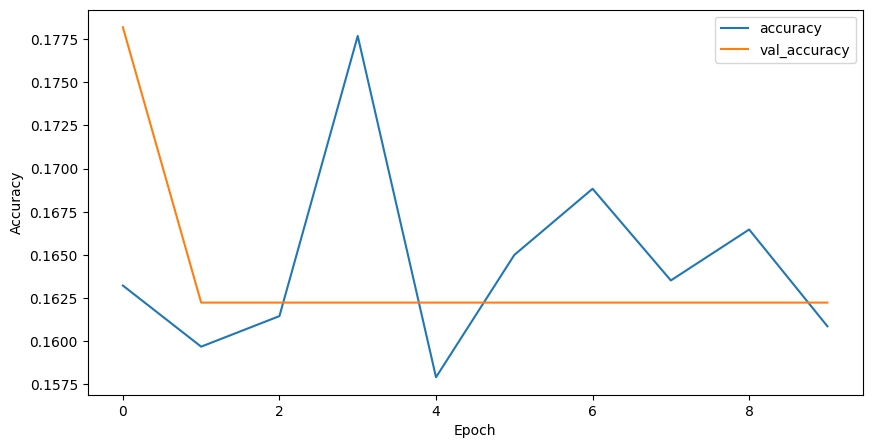

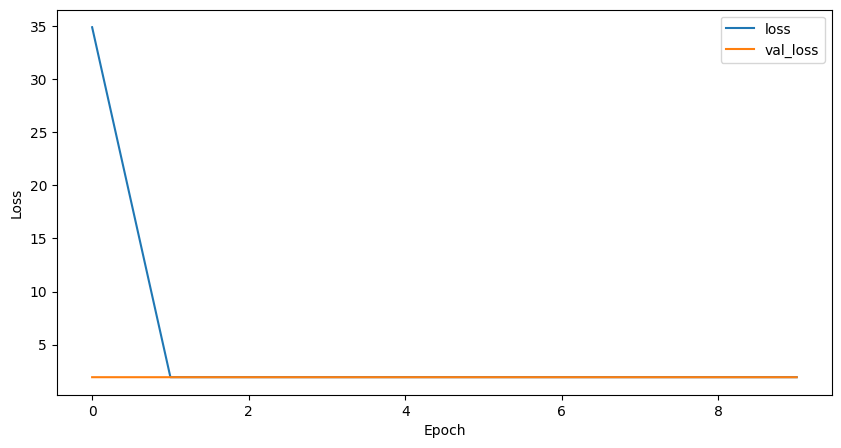

In [121]:
# plot history of training
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [111]:
# Save the model
model.save("models/instrument-recognition-1.keras")
